Berikut merupakan library yang digunakan pada script ini:
-> Digunakan numpy untuk mengolah data karena Numpy menyediakan fungsi yang siap pakai untuk memudahkan kita melakukan perhitungan saintifik seperti matriks, aljabar, statistik, dan sebagainya.

-> Pandas digunakan untuk mengolah data menjadi bentuk tabular.

-> Matplotlib digunakan untuk melakukan visualisasi data.

-> Digunakan scipy untuk melakukan FFT

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, signal, stats
from tqdm.notebook import tqdm

In [2]:

#Fucntion for import data
for dirname, _, filenames in os.walk('Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Dataset/Healthy/h30hz80.csv
Dataset/Healthy/h30hz10.csv
Dataset/Healthy/h30hz90.csv
Dataset/Healthy/h30hz20.csv
Dataset/Healthy/h30hz40.csv
Dataset/Healthy/h30hz60.csv
Dataset/Healthy/h30hz50.csv
Dataset/Healthy/h30hz70.csv
Dataset/Healthy/h30hz30.csv
Dataset/Healthy/h30hz0.csv
Dataset/BrokenTooth/b30hz20.csv
Dataset/BrokenTooth/b30hz10.csv
Dataset/BrokenTooth/b30hz40.csv
Dataset/BrokenTooth/b30hz90.csv
Dataset/BrokenTooth/b30hz80.csv
Dataset/BrokenTooth/b30hz70.csv
Dataset/BrokenTooth/b30hz50.csv
Dataset/BrokenTooth/b30hz0.csv
Dataset/BrokenTooth/b30hz60.csv
Dataset/BrokenTooth/b30hz30.csv


In [3]:
dfs = []
for dirname, _, filenames in tqdm(os.walk('Dataset')):
    for filename in tqdm(filenames, leave=False):
        
        # the gearbox state is in the filename prefix (h = healthy, b = broken tooth)
        state = filename[0]
        
        # the load is in the filename suffix
        load = int(filename.split('.')[0][5:])
        
        # read in the file
        df = pd.read_csv(os.path.join(dirname, filename))
        
        # include the healthy/broken state
        df['state'] = state
        
        # include the load
        df['load'] = load
        
        # append to a list
        dfs.append(df)

# concatenate all the datasets and reset the index
df = pd.concat(dfs).reset_index().rename(columns={'index':'sample_index'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [93]:
dfx = []
for dirname, _, filenames in tqdm(os.walk('Dataset')):
    for filename in tqdm(filenames, leave=False):
    
        
        # read in the file
        dfj = pd.read_csv(os.path.join(dirname, filename))
        
        
        # append to a list
        dfs.append(dfj)

# concatenate all the datasets and reset the index
dfj = pd.concat(dfs).reset_index().rename(columns={'index':'sample_index'})

dfj

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,sample_index,a1,a2,a3,a4,state,load
0,0,5.184420,3.811870,6.139190,-3.451860,h,80.0
1,1,24.187500,-4.558100,0.057864,3.032330,h,80.0
2,2,-5.527750,1.137570,1.709770,9.440420,h,80.0
3,3,-6.597390,-2.922210,4.404920,-3.460790,h,80.0
4,4,16.591200,5.151250,-5.919860,-9.139450,h,80.0
...,...,...,...,...,...,...,...
6063352,89851,6.404300,-3.378610,2.227520,-0.397981,NaN,NaN
6063353,89852,4.374380,-2.926590,-1.631580,-2.984510,NaN,NaN
6063354,89853,1.542940,-0.811829,-6.325190,-4.545420,NaN,NaN
6063355,89854,0.742917,0.324594,-6.365880,-3.916870,NaN,NaN


In [4]:
sensor_readings = df.melt(
    id_vars=['sample_index','state','load'],
    value_vars=['a2','a3','a4'],
    var_name='sensor',
    value_name='reading'
)

In [5]:
# helper function to filter the dataset
def rdg(df, state=None, load=None, sensor=None):
    df_st = df[df.state==state] if state is not None else df
    df_lo = df_st[df_st.load==load] if load is not None else df_st
    df_se = df_lo[df_lo.sensor==sensor] if sensor is not None else df_lo
    return df_se

In [41]:
import scipy.signal

loads = 80

x_a2 = rdg(sensor_readings, 'b', loads, 'a2').reading.values[:]
x_a3 = rdg(sensor_readings, 'b', loads, 'a3').reading.values[:]
x_a4 = rdg(sensor_readings, 'b', loads, 'a4').reading.values[:]

b, a = scipy.signal.butter(3, [0.018,0.02],  btype='bandpass') #Filter
x_a2 = scipy.signal.lfilter(b, a, x_a2)
x_a3 = scipy.signal.lfilter(b, a, x_a3)
x_a4 = scipy.signal.lfilter(b, a, x_a4)


df_filter = pd.DataFrame({'a2': x_a2,
                  'a3': x_a3,
                  'a4': x_a4})

df_filter.to_csv("b30hz80.csv", index = False)

df_filter



,a2,a3,a4
0,-1.438713e-07,-8.614338e-09,-6.675901e-08
1,-1.078563e-06,-2.470471e-07,-4.236775e-07
2,-3.854240e-06,-1.618066e-06,-1.066833e-06
3,-8.974406e-06,-5.737705e-06,-1.009162e-06
4,-1.578006e-05,-1.401830e-05,1.438316e-06
...,...,...,...
110330,1.988817e-02,4.198560e-02,-1.606365e-01
110331,2.269141e-02,4.260383e-02,-1.671203e-01
110332,2.541003e-02,4.305022e-02,-1.730452e-01
110333,2.803411e-02,4.332271e-02,-1.783900e-01


## Frequency Analysis

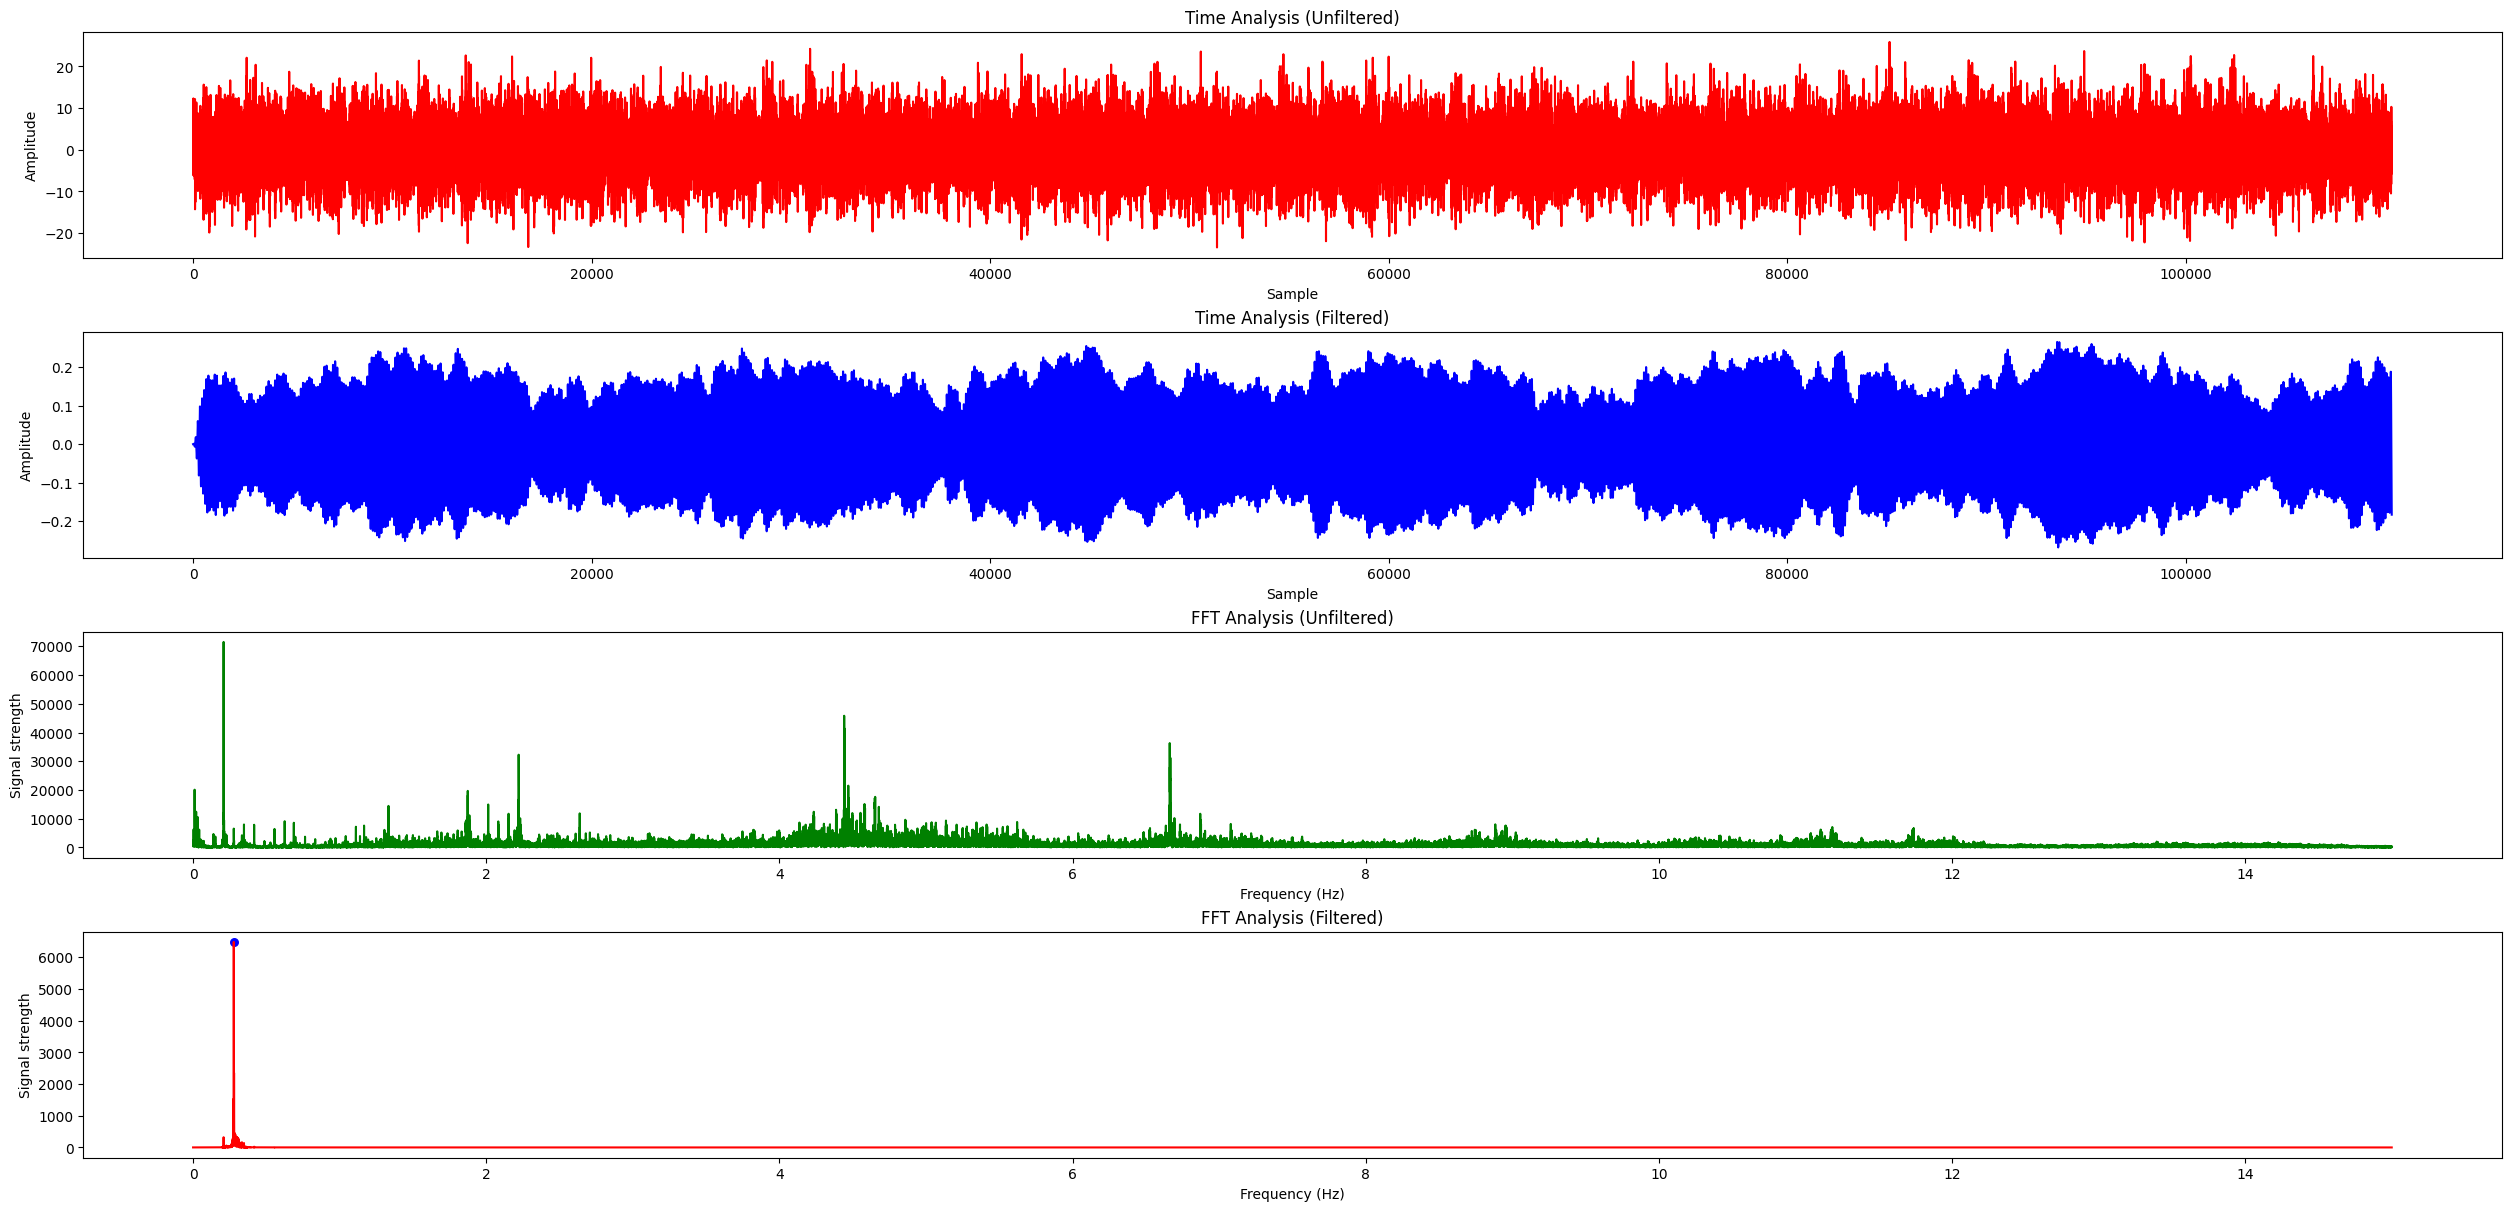

In [7]:
import scipy.signal

x = rdg(sensor_readings, 'b', 80, 'a4').reading.values[:]

b, a = scipy.signal.butter(3, [0.018,0.02],  btype='bandpass') #Filter
x_filtered = scipy.signal.lfilter(b, a, x)

y_nf = np.abs(fft.rfft(x))
x_nf = fft.rfftfreq(x.shape[0], 1/30) 

y_fft = np.abs(fft.rfft(x_filtered))
x_fft = fft.rfftfreq(x_filtered.shape[0], 1/30)  # 30Hz data rate

# find peaks that are
#   at least 1Hz apart (number of frequency points / max frequency)
x_peak_spacing = y_fft.shape[0] / x_fft.max()
#   rising above surrounding values by the 99th percentile of the values
x_peak_prominence = np.quantile(y_fft,0.99)

abnormal_peaks, _ = signal.find_peaks(y_fft, distance=x_peak_spacing, prominence=x_peak_prominence)



fig, ax = plt.subplots(4,1, figsize=(25,12), constrained_layout = True)
ax[0].plot(x, color='red')
ax[1].plot(x_filtered, color='blue')
ax[2].plot(x_nf, y_nf, color='green')
ax[3].plot(x_fft, y_fft, color='red')
for peak in abnormal_peaks:
    ax[3].scatter(x=x_fft[peak], y=y_fft[peak], c='b', marker='o', s=30)

# for xz in range(4):
#     if xz < 2:
#         ax[xz].set_title()
#         ax[xz].set_xlabel('Sample')
#         ax[xz].set_ylabel('Amplitude')
#     else:
#         ax[xz].set_xlabel('Frequency (Hz)')
#         ax[xz].set_ylabel('Signal strength')
ax[0].set_title("Time Analysis (Unfiltered)")
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Amplitude')

ax[1].set_title("Time Analysis (Filtered)")
ax[1].set_xlabel('Sample')
ax[1].set_ylabel('Amplitude')

ax[2].set_title("FFT Analysis (Unfiltered)")
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_ylabel('Signal strength')

ax[3].set_title("FFT Analysis (Filtered)")
ax[3].set_xlabel('Frequency (Hz)')
ax[3].set_ylabel('Signal strength')
plt.show()

## Neural Network Classification

In [49]:
data = []
labels = []
for (state,load,sensor),g in sensor_readings.groupby(['state','load','sensor']):
    vals = g.reading.values
    splits = np.split(vals, range(1000,vals.shape[0],1000))
    for s in splits[:-1]:  # except the last one
        data.append({
            #'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            'sensor_a4': int(sensor=='a4'),
            # no need to put a4: if a1-3 are 0, then it's sensor a4
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
            'moment': stats.moment(s),
        })
        labels.append(int(state=='b'))  # positive label indicates fault

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
(data.shape, labels.shape)

((1824, 9), (1824,))

In [20]:
from sklearn.preprocessing import MinMaxScaler

# define min max scaler
scaler = MinMaxScaler()
# transform data
data = scaler.fit_transform(data)
print(data)

[[0.         0.         0.         ... 0.19965077 0.51543001 0.        ]
 [0.         0.         0.         ... 0.08482046 0.45463775 0.        ]
 [0.         0.         0.         ... 0.23778072 0.565675   0.        ]
 ...
 [0.         0.         1.         ... 0.0913045  0.43189708 0.        ]
 [0.         0.         1.         ... 0.0681566  0.47789018 0.        ]
 [0.         0.         1.         ... 0.12918769 0.53597226 0.        ]]


In [66]:
b, a = scipy.signal.butter(3, [0.018,0.02],  btype='bandpass') #Filter
data = scipy.signal.lfilter(b, a, data)

In [83]:
data = pd.DataFrame(data)
display(data)

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.022667,3.655042,1.463576,0.002936,0.0
1,0.0,0.0,0.0,0.0,-0.010693,3.512694,0.569197,-0.109014,0.0
2,0.0,0.0,0.0,0.0,0.024794,3.480711,1.760559,0.095463,0.0
3,0.0,0.0,0.0,0.0,0.022342,3.121883,0.412319,-0.040594,0.0
4,0.0,0.0,0.0,0.0,0.001597,3.466257,0.208529,-0.065250,0.0
...,...,...,...,...,...,...,...,...,...
8031,0.0,0.0,1.0,90.0,-0.057993,5.126656,0.734330,-0.117967,0.0
8032,0.0,0.0,1.0,90.0,0.197871,4.979485,0.922546,-0.232759,0.0
8033,0.0,0.0,1.0,90.0,0.117545,5.536792,0.619699,-0.150892,0.0
8034,0.0,0.0,1.0,90.0,-0.212632,5.188033,0.439407,-0.066195,0.0


In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    train_size=0.8,
    random_state=42,
    stratify=labels
)
print(f'Training data: {X_train.shape}')
print(f'Test data: {X_test.shape}')

Training data: (1459, 9)
Test data: (365, 9)


In [51]:
#Import svm model
from sklearn import svm
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
clf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.68      0.62       189
           1       0.56      0.43      0.49       176

    accuracy                           0.56       365
   macro avg       0.56      0.56      0.55       365
weighted avg       0.56      0.56      0.55       365



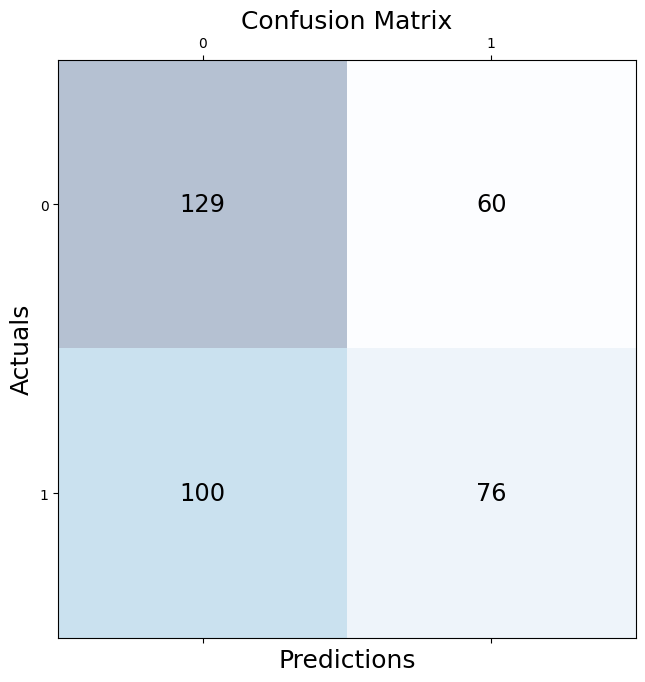

In [53]:
from sklearn.metrics import confusion_matrix

#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

y_gb = gb_clf.predict(X_test)

Learning rate:  0.05
Accuracy score (training): 0.572
Accuracy score (validation): 0.523
Learning rate:  0.075
Accuracy score (training): 0.593
Accuracy score (validation): 0.532
Learning rate:  0.1
Accuracy score (training): 0.590
Accuracy score (validation): 0.526
Learning rate:  0.25
Accuracy score (training): 0.613
Accuracy score (validation): 0.534
Learning rate:  0.5
Accuracy score (training): 0.626
Accuracy score (validation): 0.540
Learning rate:  0.75
Accuracy score (training): 0.643
Accuracy score (validation): 0.507
Learning rate:  1
Accuracy score (training): 0.631
Accuracy score (validation): 0.504


In [60]:
from tpot import TPOTClassifier

tpot_td = TPOTClassifier(generations=1, random_state=42, max_time_mins=2)
tpot_td.fit(X_train, y_train)

#y_predict = TPOTClassifier.predict(X_test)

print(f'Best accuracy score: {tpot_td.score(X_test, y_test):0.3%}')

Best accuracy score: 86.007%


/home/norris/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:765: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


In [36]:
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, ConfusionMatrixDisplay, plot_confusion_matrix


In [62]:
cm = confusion_matrix(y_test, y_gb)
cm

array([[652, 156],
       [147, 653]])

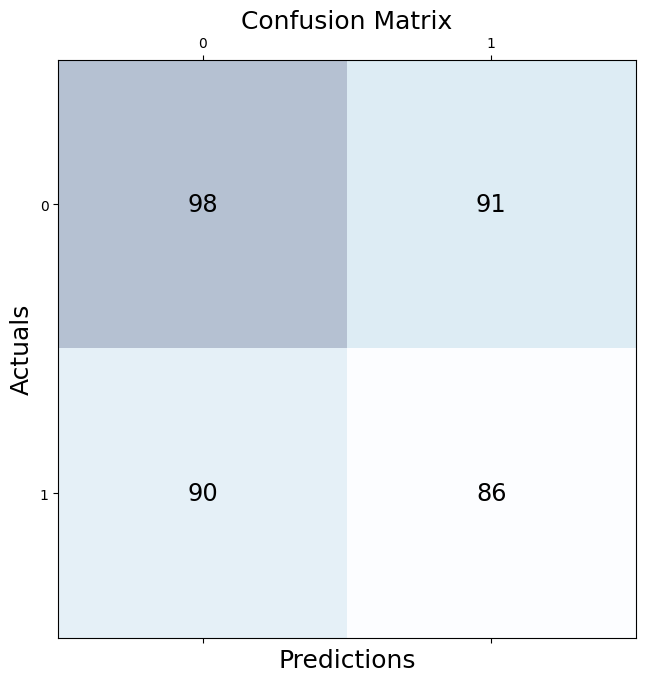

In [55]:
 
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_gb)


fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()